### Reference from https://github.com/Hvass-Labs/TensorFlow-Tutorials

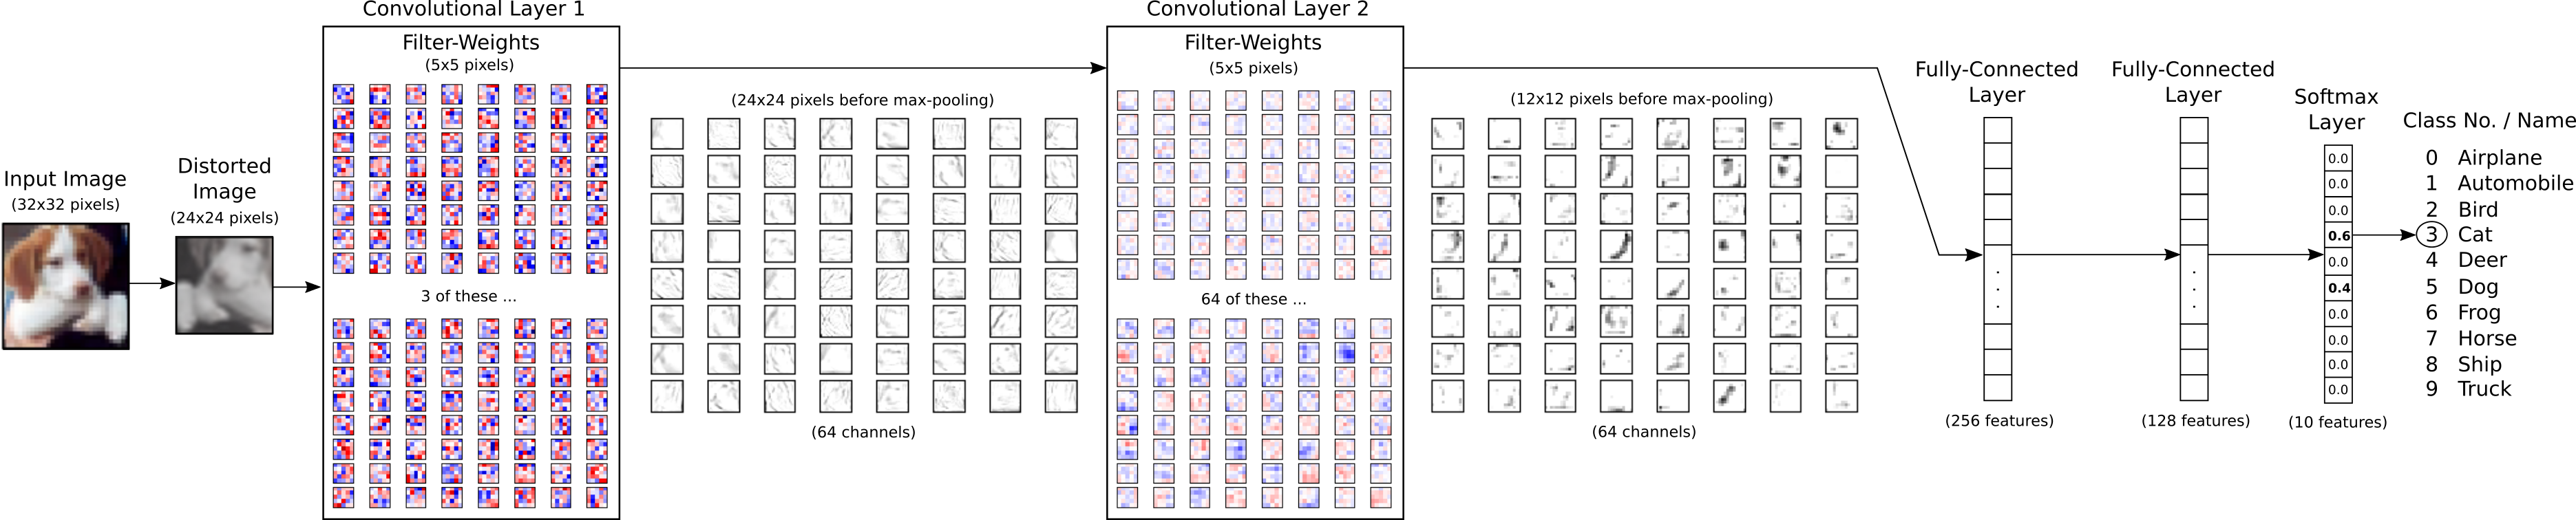

In [1]:
from IPython.display import Image
Image('06_network_flowchart.png')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import help_function as h
# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt


# Download CIFAR10 

download.maybe_download_and_extract(url=data_url, download_dir=data_path)

data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

data_path = "data/CIFAR-10/"


In [3]:
import cifar10
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


# CIFAR 10 Attributres

## Classes in CIFAR10

In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Load Training Data

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [6]:
print(images_train.shape)
print(labels_train.shape)
print(cls_train.shape)

(50000, 32, 32, 3)
(50000, 10)
(50000,)


In [7]:
images_test, cls_test, labels_test = cifar10.load_test_data()
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Size of:
- Training-set:		50000
- Test-set:		10000


In [8]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

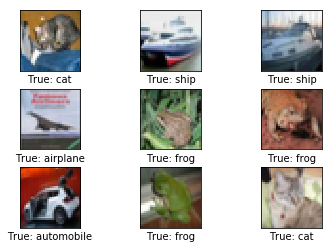

In [9]:


# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)


# Buildup Placeholder

In [10]:
from cifar10 import img_size, num_channels, num_classes
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [11]:
import help_function as h
distorted_images = h.pre_process(images=x, training=True)

# Main Architechture of Model

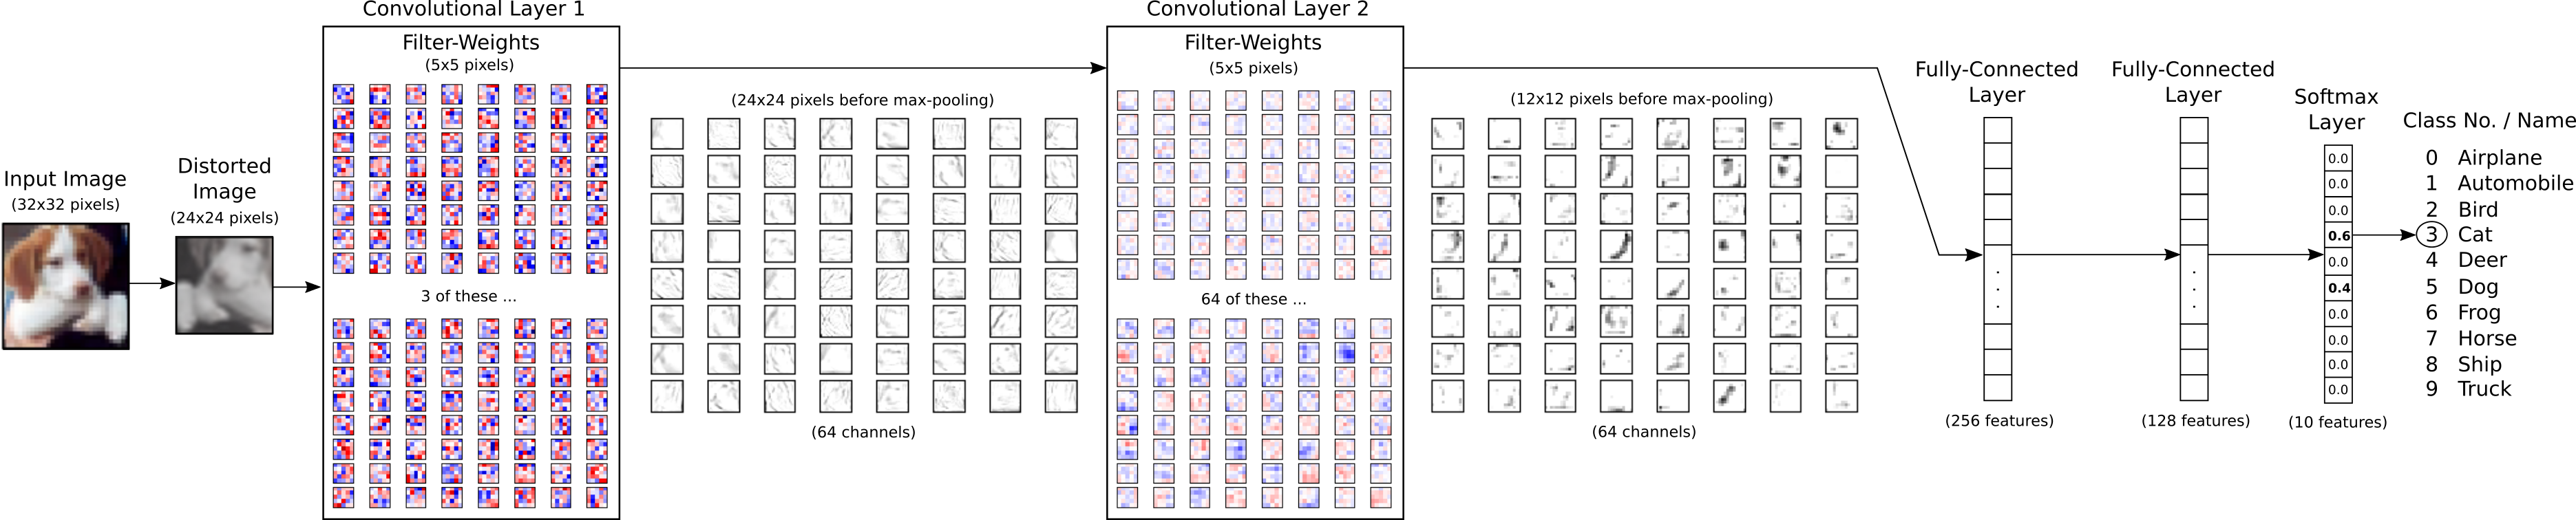

In [12]:
Image('06_network_flowchart.png')

In [13]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

# Create network

In [14]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = h.pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

# Build a Graph for Training

In [15]:
_, loss = create_network(training=True)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

# Build a Graph for Test

In [16]:
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

# Saver for saving model

In [18]:
saver = tf.train.Saver()

save_dir = 'checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'cifar10_cnn')

# Start Runing your Session

In [19]:
session = tf.Session()

## Restore your model if exist or Initial form draft

In [20]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
Failed to restore checkpoint. Initializing variables instead.


## Determine Batch Size

In [21]:
train_batch_size = 64
num_iterations = 10

## Start Training your model

In [22]:
start_time = time.time()

for i in range(num_iterations):
    # Get a batch of training examples.
    # x_batch now holds a batch of images and
    # y_true_batch are the true labels for those images.
    x_batch, y_true_batch = h.random_batch(images_train, labels_train, train_batch_size)

    # Put the batch into a dict with the proper names
    # for placeholder variables in the TensorFlow graph.
    feed_dict_train = {x: x_batch,
                       y_true: y_true_batch}

    # Run the optimizer using this batch of training data.
    # TensorFlow assigns the variables in feed_dict_train
    # to the placeholder variables and then runs the optimizer.
    # We also want to retrieve the global_step counter.
    i_global, _ = session.run([global_step, optimizer],
                              feed_dict=feed_dict_train)

    # Print status to screen every 100 iterations (and last).
    if (i_global % 100 == 0) or (i == num_iterations - 1):
        # Calculate the accuracy on the training-batch.
        batch_acc = session.run(accuracy,
                                feed_dict=feed_dict_train)

        # Print status.
        msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
        print(msg.format(i_global, batch_acc))

    # Save a checkpoint to disk every 1000 iterations (and last).
    if (i_global % 1000 == 0) or (i == num_iterations - 1):
        # Save all variables of the TensorFlow graph to a
        # checkpoint. Append the global_step counter
        # to the filename so we save the last several checkpoints.
        saver.save(session,
                   save_path=save_path,
                   global_step=global_step)

        print("Saved checkpoint.")

# Ending time.
end_time = time.time()

# Difference between start and end-times.
time_dif = end_time - start_time

# Print the time-usage.
print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

Global Step:      0, Training Batch Accuracy:  10.9%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  15.6%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  10.9%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  15.6%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  12.5%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  17.2%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:   7.8%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  15.6%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  14.1%
Saved checkpoint.
Global Step:      0, Training Batch Accuracy:  14.1%
Saved checkpoint.
Time usage: 0:00:03


## Predict Test Class  & Plot Results

In [23]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [24]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [28]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

In [27]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

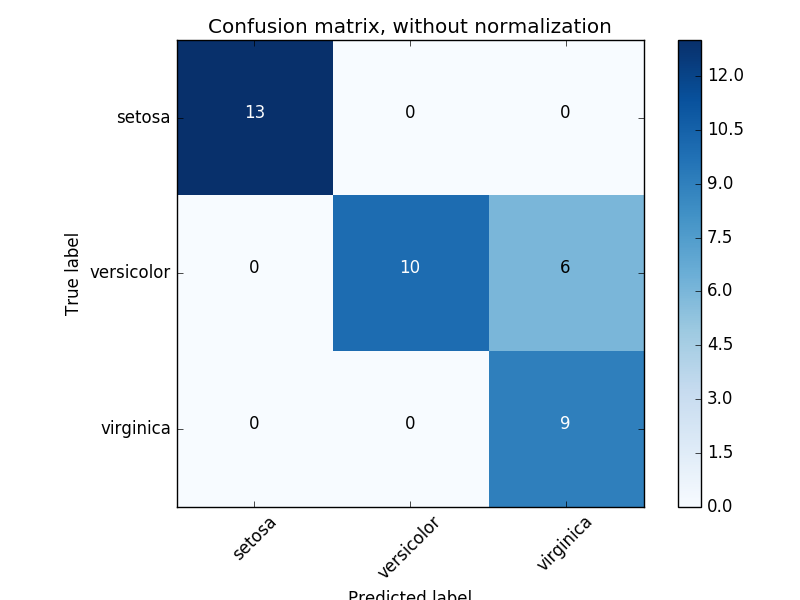

In [31]:
Image('confusion_matrix.png')

In [29]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

Accuracy on Test-Set: 12.7% (1270 / 10000)
Example errors:


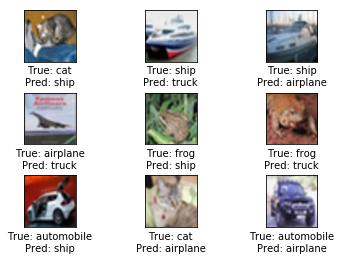

Confusion Matrix:
[535   0   3  16   0 129   4   5 187 121] (0) airplane
[430   0  10  34   0 152   7   9 139 219] (1) automobile
[386   4   5  51   0  97  31   0 271 155] (2) bird
[447   3   4  94   0 121  13   4 188 126] (3) cat
[345   1   7  93   1  63  37   6 262 185] (4) deer
[459   2   3  70   0  85  17   2 234 128] (5) dog
[312   0  12  97   4  65  44  13 267 186] (6) frog
[464   3   6 112   1  86  15   6 171 136] (7) horse
[381   0   2  16   0 214   1   0 196 190] (8) ship
[452   0   4  18   1 117   3   6  95 304] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [30]:
show_example_errors = True
show_confusion_matrix = True
# For all the images in the test-set,
# calculate the predicted classes and whether they are correct.
correct, cls_pred = predict_cls_test()

# Classification accuracy and the number of correct classifications.
acc, num_correct = classification_accuracy(correct)

# Number of images being classified.
num_images = len(correct)

# Print the accuracy.
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, num_correct, num_images))

# Plot some examples of mis-classifications, if desired.
if show_example_errors:
    print("Example errors:")
    plot_example_errors(cls_pred=cls_pred, correct=correct)

# Plot the confusion matrix, if desired.
if show_confusion_matrix:
    print("Confusion Matrix:")
    plot_confusion_matrix(cls_pred=cls_pred)

# Plot Convolution Weight

In [33]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

In [32]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Min:  -0.63931, Max:   0.62771
Mean: -0.00023, Stdev: 0.16474


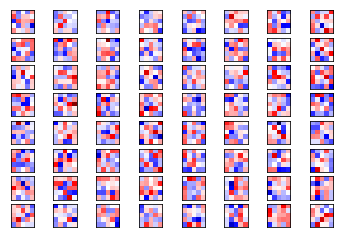

In [34]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

Min:  -0.16457, Max:   0.14538
Mean: -0.00003, Stdev: 0.03537


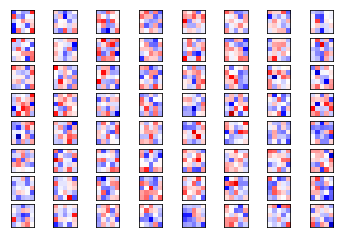

In [35]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

# Plot image after convolution

In [40]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]


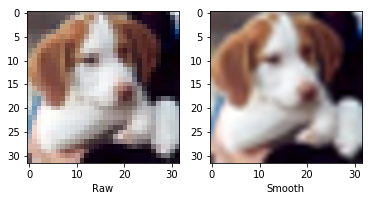

In [42]:
img, cls = get_test_image(16)
plot_image(img)

In [43]:
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [44]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

In [45]:
def plot_layer_output(layer_output, image):
    # Assume layer_output is a 4-dim tensor
    # e.g. output_conv1 or output_conv2.

    # Create a feed-dict which holds the single input image.
    # Note that TensorFlow needs a list of images,
    # so we just create a list with this one image.
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Get the lowest and highest values.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

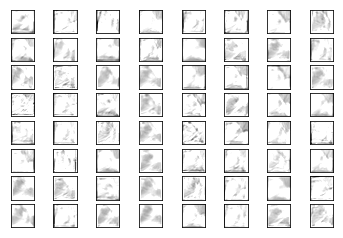

In [46]:
plot_layer_output(output_conv1, image=img)

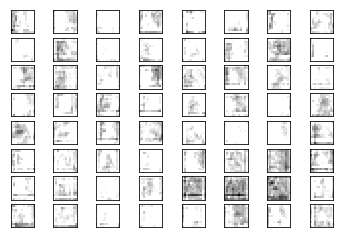

In [47]:
plot_layer_output(output_conv2, image=img)